In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.datasets import load_breast_cancer 
from sklearn import decomposition, datasets
from sklearn.svm import SVC, SVR
import os, sys
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch
from torchvision import models
import datetime

In [3]:
!pip install roboflow

from roboflow import Roboflow 
rf = Roboflow(api_key="DXb4B94A1xpmpoSfBs45")
project = rf.workspace("itml-project").project("itml-final-project-ai-versus-non-ai-dataset")
dataset = project.version(4).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 945 kB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 145 kB 66.3 MB/s 
     |████████████████████████████████| 178 kB 60.7 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 138 kB 81.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=d883c99b1e80fc547108448b62da59183d19c831a9ee0597c0c02f4e450c5150
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certi

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ITML-Final-Project-AI-versus-Non-AI-Dataset-4 in folder:: 100%|██████████| 1900/1900 [00:01<00:00, 1862.33it/s]


In [4]:
data_loc= dataset.location

In [5]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
])

In [6]:
from torchvision.datasets import ImageFolder
ai_train = data_loc + '/train'
ai_val = data_loc + '/valid'
ai_train_set = ImageFolder(ai_train,transform = preprocess)
ai_val_set = ImageFolder(ai_val, transform = preprocess)

In [7]:
ai_test = ImageFolder(ai_train)

In [8]:

imgs = torch.stack([img_t for img_t, _ in ai_train_set], dim=3)
imgs.shape

torch.Size([3, 256, 256, 1318])

In [9]:
imgs.view(3, -1).mean(dim=1)  # <1>

tensor([0.4763, 0.4478, 0.3608])

In [10]:
imgs.view(3, -1).std(dim=1)

tensor([0.2615, 0.2591, 0.2699])

In [11]:
preprocess2 = transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.4763, 0.4478, 0.3608],
        std=[0.2615, 0.2591, 0.2699])
])

In [12]:
ai_train_set = ImageFolder(ai_train,transform = preprocess2)
ai_val_set = ImageFolder(ai_val, transform = preprocess2)

In [13]:
model = models.resnet18(weights = None)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [15]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print('{} Epoch {}, Training loss {}'.format(
    datetime.datetime.now(), epoch,
    loss_train / len(train_loader)))

In [16]:
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in loader:
          imgs, labels = imgs.to(device), labels.to(device)
          batchsize = imgs.shape[0]
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name , correct / total))

In [17]:
ai_train_set

Dataset ImageFolder
    Number of datapoints: 1318
    Root location: /content/ITML-Final-Project-AI-versus-Non-AI-Dataset-4/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4763, 0.4478, 0.3608], std=[0.2615, 0.2591, 0.2699])
           )

In [22]:
ai_val_set

Dataset ImageFolder
    Number of datapoints: 374
    Root location: /content/ITML-Final-Project-AI-versus-Non-AI-Dataset-4/valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4763, 0.4478, 0.3608], std=[0.2615, 0.2591, 0.2699])
           )

In [18]:
train_loader = torch.utils.data.DataLoader(ai_train_set, batch_size=64,
                                           shuffle=True)  # <1>

model = model.to(device=device)  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-3)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-12-14 14:54:33.441716 Epoch 1, Training loss 5.702245621454148
2022-12-14 14:55:04.550060 Epoch 2, Training loss 2.9066319238571894
2022-12-14 14:55:34.888148 Epoch 3, Training loss 1.2909555860928126
2022-12-14 14:56:04.534157 Epoch 4, Training loss 0.7927590296381996
2022-12-14 14:56:34.434534 Epoch 5, Training loss 0.6444297972179595
2022-12-14 14:57:04.137431 Epoch 6, Training loss 0.5655732736701057
2022-12-14 14:57:33.945450 Epoch 7, Training loss 0.5199360308193025
2022-12-14 14:58:03.724859 Epoch 8, Training loss 0.4876305191289811
2022-12-14 14:58:33.437790 Epoch 9, Training loss 0.46879325878052486
2022-12-14 14:59:03.345188 Epoch 10, Training loss 0.45089096966243924


In [1]:
train_loader = torch.utils.data.DataLoader(ai_train_set, batch_size = 64,
                                           shuffle=False)  # <1>
val_loader = torch.utils.data.DataLoader(ai_val_set, batch_size = 64,
                                           shuffle=False)  # <1>

validate(model, train_loader, val_loader)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        inputs=inputs.to(device); labels=labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().detach().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('nonai','AI')

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


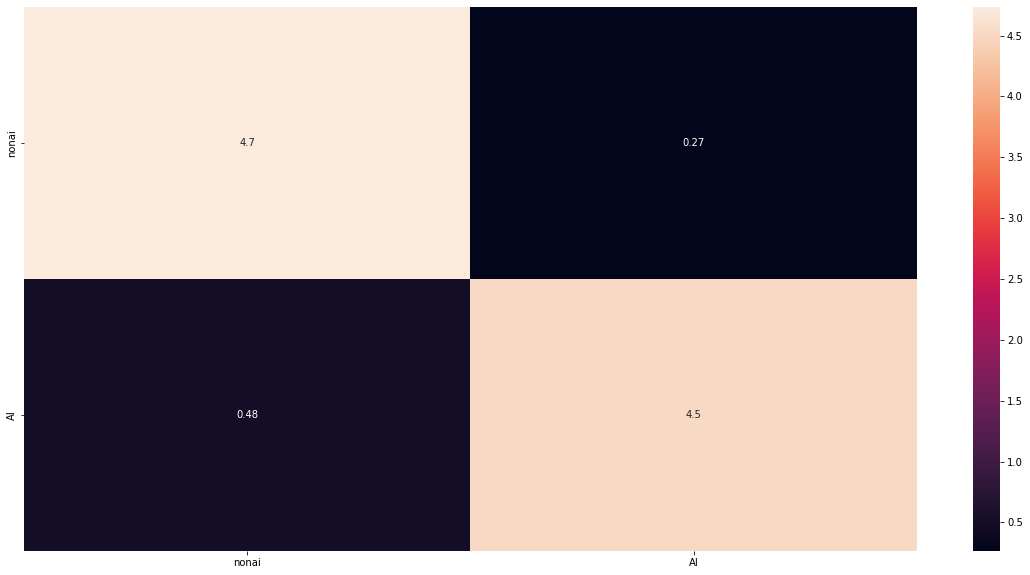

In [ ]:
# Build confusion matrix
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('CnfMatrix_ResNet18_1.png')